# Jogo Organelas - Conhecendo as organelas de uma célula - EICA
This file is part of program Organela
Copyright © 2022 Carlo Oliveira carlo@nce.ufrj.br,
Labase <http://labase.selfip.org/>; GPL <http://is.gd/3Udt>.
SPDX-License-Identifier: (GPLv3-or-later AND LGPL-2.0-only) WITH bison-exception

## Análise dos dados da API de coleta para obtenção de estados EICA
Observa os dados numa série temporal para obtenção dos Estados EICA.
[!NOTE]
codeauthor:: Carlo Oliveira [carlo at ufrj](mailto:carlo@ufrj.br)

## Changelog

<!--![version added](https://raw.githubusercontent.com/FortAwesome/Font-Awesome/6.x/svgs/solid/circle-plus.svg)  22.06-->
<img src="https://raw.githubusercontent.com/FortAwesome/Font-Awesome/6.x/svgs/solid/circle-plus.svg" width=16/>  22.06

* Extração do código EICA
* Características dos estados EICA
* Estudo das transições/palavras
* Estudo dos falantes por transição


In [5]:
import urllib.request
from json import loads
import pandas as pd
lisa_score_url = "https://raw.githubusercontent.com/kwarwp/lorinda/master/lisa/__score__.py"
f00 = "{'doc_id': 'a42ac145', 'carta': 'parte_1', 'casa': 'Fase0', 'move': 'local', 'ponto': 0, 'valor': 'local', '_level': 1, 'tempo': ".replace("'", '"')
try:
    with urllib.request.urlopen(lisa_score_url) as f, open("lisa_score.csv", "w") as score_csv:
        lisa_score = f.read().decode('utf-8').replace("'", '"').replace("Fase","Fase0").replace("Fase011","Fase11")
        lisa_score = f"[{lisa_score[:-2]}]"
        lisa_score = loads(lisa_score)
        headings = ['doc_id', 'carta', 'casa', 'move', 'ponto', 'valor', '_level', 'tempo']
        datan = {key: [] for key in headings}
        [datan[key].append(val) for line in lisa_score for key, val in line.items() if key in headings]
        df = pd.DataFrame(datan)
        df.sort_values(by=['doc_id','tempo',], inplace=True)
        df["movetime"] = df.groupby('doc_id').tempo.diff()
        df = df[df.groupby(['doc_id'])['movetime'].transform('sum') > 100000]
        df.tempo = pd.to_datetime(df.tempo)
        df.info()
except urllib.error.URLError as e:
    print(e.reason)
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3217 entries, 2119 to 3065
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   doc_id    3217 non-null   object        
 1   carta     3217 non-null   object        
 2   casa      3217 non-null   object        
 3   move      3217 non-null   object        
 4   ponto     3217 non-null   int64         
 5   valor     3217 non-null   object        
 6   _level    3217 non-null   int64         
 7   tempo     3217 non-null   datetime64[ns]
 8   movetime  3181 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 251.3+ KB


,doc_id,carta,casa,move,ponto,valor,_level,tempo,movetime
2119,04371ac6,parte_0,Fase01,local,0,local,1,1970-01-01 00:27:34.697539054,NaN
2120,04371ac6,parte_e,Fase01,local,0,local,1,1970-01-01 00:27:34.697539278,224.0
2121,04371ac6,parte_0,Fase00,local,0,local,1,1970-01-01 00:27:34.697539505,227.0
2122,04371ac6,parte_1,Fase00,local,0,local,1,1970-01-01 00:27:34.697539643,138.0
2123,04371ac6,parte_1,Fase00,local,0,local,1,1970-01-01 00:27:34.697539776,133.0
...,...,...,...,...,...,...,...,...,...
3059,f74fcfaf,parte_3,Fase09,local,0,local,1,1970-01-01 00:27:34.701279729,3702.0
3060,f74fcfaf,parte_4,Fase07,local,0,local,1,1970-01-01 00:27:34.701309805,30076.0
3061,f74fcfaf,parte_5,Fase07,local,0,local,1,1970-01-01 00:27:34.701313388,3583.0
3062,f74fcfaf,parte_0,Fase11,local,0,local,1,1970-01-01 00:27:34.701320681,7293.0


## Recorte dos jogadores usando o mesmo computador
O arquivo de dados registra uma única identificação para todos os jogadores que usaram o mesmo computador. Este código separa estes jogadores baseado em registro de início de jogo.
Calcula também a velocidade de reação e a aceleração desta reação pelos participantes.


In [6]:
ddict = df.to_dict('records')
ALPHA = [a+b for a in "bcdfghjklmnpqrstvxz" for b in "01234"]
cuts = [ind for ind, dc in enumerate(ddict) if (dc['casa'] == "Fase01") and (dc["carta"] == "parte_0")]
cuts = zip(cuts, cuts[1:]+[len(df)])
cuts = list(cuts)
dcut = [{k: v if k != "doc_id" else ALPHA[ind] for k,v in dc.items()}
        for ind, (st,ed) in enumerate(cuts) for dc in ddict[st:ed]
        if ((ed-st)>10) and ind <200 and ALPHA[ind] not in "g1 k3 s1"]
dcuts = [[{k: v if k != "doc_id" else ALPHA[ind] for k, v in dc.items()} for dc in ddict[st:ed]]
         for ind, (st,ed) in enumerate(cuts) if ((ed-st)>10)]# and ind not in (6, 9, 23, 17, 19) and ind <20]
df = pd.DataFrame(dcut)
df.loc[(df["casa"] == "Fase01")&(df["carta"] == "parte_0"), "movetime"] = 111.1
df["movedelta"] = df.groupby('doc_id')['movetime'].apply(lambda x: x - x.shift(1))
df["movejump"] = df.groupby('doc_id')['movedelta'].apply(lambda x: x - x.shift(1))
df["time"] = df.groupby(['doc_id'])['movetime'].cumsum() #.apply(lambda x: x.shift()+x)
df

,doc_id,carta,casa,move,ponto,valor,_level,tempo,movetime,movedelta,movejump,time
0,b1,parte_0,Fase01,local,0,local,1,1970-01-01 00:27:34.698747018,111.1,NaN,NaN,111.1
1,b1,parte_a,Fase01,local,0,local,1,1970-01-01 00:27:34.698755153,8135.0,8023.9,NaN,8246.1
2,b1,parte_c,Fase01,local,0,local,1,1970-01-01 00:27:34.698763387,8234.0,99.0,-7924.9,16480.1
3,b1,parte_b,Fase01,local,0,local,1,1970-01-01 00:27:34.698766251,2864.0,-5370.0,-5469.0,19344.1
4,b1,parte_d,Fase01,local,0,local,1,1970-01-01 00:27:34.698779892,13641.0,10777.0,16147.0,32985.1
...,...,...,...,...,...,...,...,...,...,...,...,...
2596,x3,parte_3,Fase09,local,0,local,1,1970-01-01 00:27:34.701279729,3702.0,1302.0,1934.0,1882705.1
2597,x3,parte_4,Fase07,local,0,local,1,1970-01-01 00:27:34.701309805,30076.0,26374.0,25072.0,1912781.1
2598,x3,parte_5,Fase07,local,0,local,1,1970-01-01 00:27:34.701313388,3583.0,-26493.0,-52867.0,1916364.1
2599,x3,parte_0,Fase11,local,0,local,1,1970-01-01 00:27:34.701320681,7293.0,3710.0,30203.0,1923657.1


## Preparação para extrair séries temporais
As séries serão ajustadas para interpolação.


In [9]:
ds = df.loc[:, ['doc_id', 'time', 'movejump']]
ds['time'] = pd.to_numeric(df['time'], errors='coerce').fillna(0).astype(int)
ds.index = ds['time'].div(1000).astype(int)
del ds['time']
dfs = {did:x.iloc[:64,:] for did, x in ds.groupby('doc_id') if x.index[-1] > 400}


## Discriminador dos estados EICA
A partir da segunda derivada das ações do participante, o wavelet separa as transições essenciais. Derivando os wavelets podemos determinar os coeficientes angulares característicos dos estados EICA

In [10]:
def discriminate_eica_states(data_frame):
    sencond_deriv = data_frame['movejump'].values
    tim = data_frame.index.values
    from scipy.interpolate import interp1d
    import numpy as npy
    from math import log, isnan
    linear_time_space_ = npy.linspace(tim[0], tim[-1], (tim[-1] - tim[0]))
    interpolating_function_ = interp1d(tim, sencond_deriv, kind='slinear')
    y_inter= interpolating_function_(linear_time_space_)
    import pywt
    wlet = pywt.Wavelet('db3')
    _,y_wav = pywt.dwt(y_inter, wlet) #'bior1.3')
    y_wav = [0 if isnan(_y) else log(_y) if _y > 0 else -log(abs(_y)+0.05) for _y in y_wav]
    y_wav = [y1 - y0 for y0, y1 in zip(y_wav, y_wav[1:]+[0])]
    y_wav = [int((_y+40)//25) for _y in y_wav]
    # y_wav_size = len(y_wav)
    eica = [(tempo, a+b*3+b*9) for tempo,a,b,c in zip(linear_time_space_, y_wav, y_wav[+1:]+[0], y_wav[+2:]+[0,0])][::3]
    # eica_states = list(set(eica))
    return eica
# all_states = [dict(aut=aut, st=st) for aut, df_ in enumerate(dfs) for st in discriminate_eica_states(df_)]
all_states = [dict(aut=aut, st=st, tempo=tempo) for aut, df_ in dfs.items() for tempo,st in discriminate_eica_states(df_)]
df_states = pd.DataFrame(all_states)
# df_states["st"] = df_states["st"].map({k: f"est{v}" for v, k in enumerate([13,24, 1, 14,25,2,12])})
df_states["st"] = df_states["st"].map({k: f"est{v}" for v, k in enumerate([13,24, 14, 1,25,2,12])})

df_states

,aut,st,tempo
0,b1,est0,0.000000
1,b1,est0,3.003947
2,b1,est0,6.007895
3,b1,est0,9.011842
4,b1,est4,12.015789
...,...,...,...
4051,x3,est6,747.492419
4052,x3,est3,750.494397
4053,x3,est2,753.496374
4054,x3,est0,756.498352


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt


## Distribuição estatística das incidências dos estados EICA
Os estados EICA tem um perfil de incidência caractístico, desde os mais frequentes até os menos frequentes.

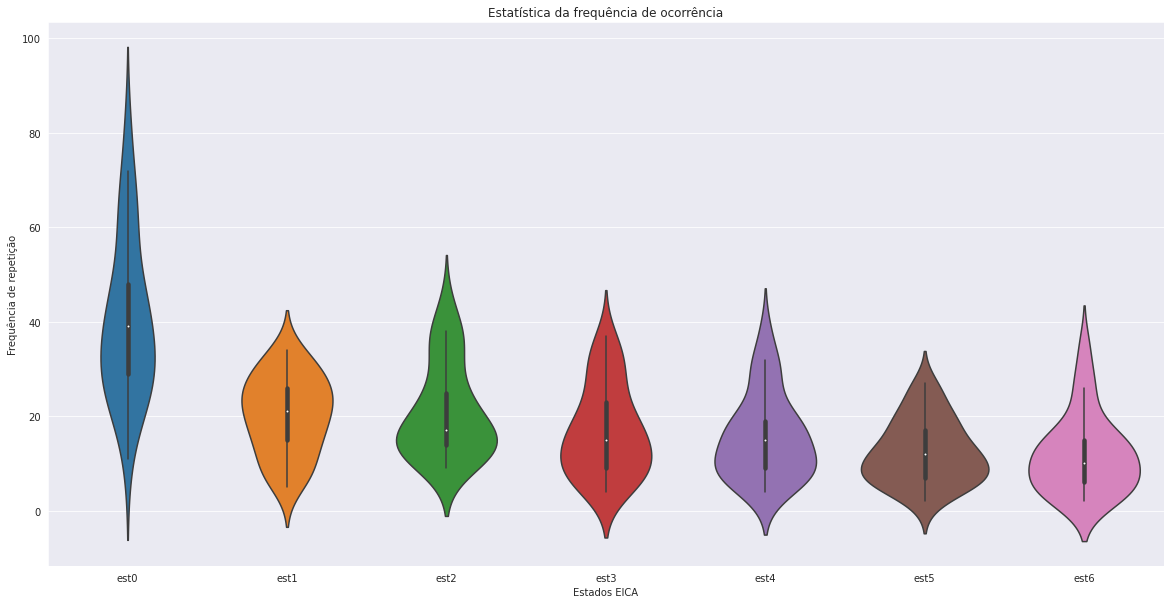

In [12]:
dst_cnt = df_states.groupby(["aut"])["st"].value_counts()
dst_dct = [dict(aut=aut, st=st, stc=stc) for (aut, st), stc in dst_cnt.to_dict().items() if st not in (0, 37, 36, 26,3)]
df_st_cnt = pd.DataFrame(dst_dct)
# df_states['st_cnt'] = df_states["st"].map(dst_dct)
# sns.violinplot(x="st", y="stc", data=df_st_cnt, order=[13,24, 1, 14,25,2,12]) # , 36, 26, 3])
sns.violinplot(x="st", y="stc", data=df_st_cnt, order=[f"est{v}" for v in range(7)]).set(
    title="Estatística da frequência de ocorrência", xlabel="Estados EICA", ylabel="Frequência de repetição")

plt.gcf().set_size_inches(20, 10)

## Intervalo de ocorrência entre cada estado
Avalia o quanto demora para um estado reaparecer na série temporal.

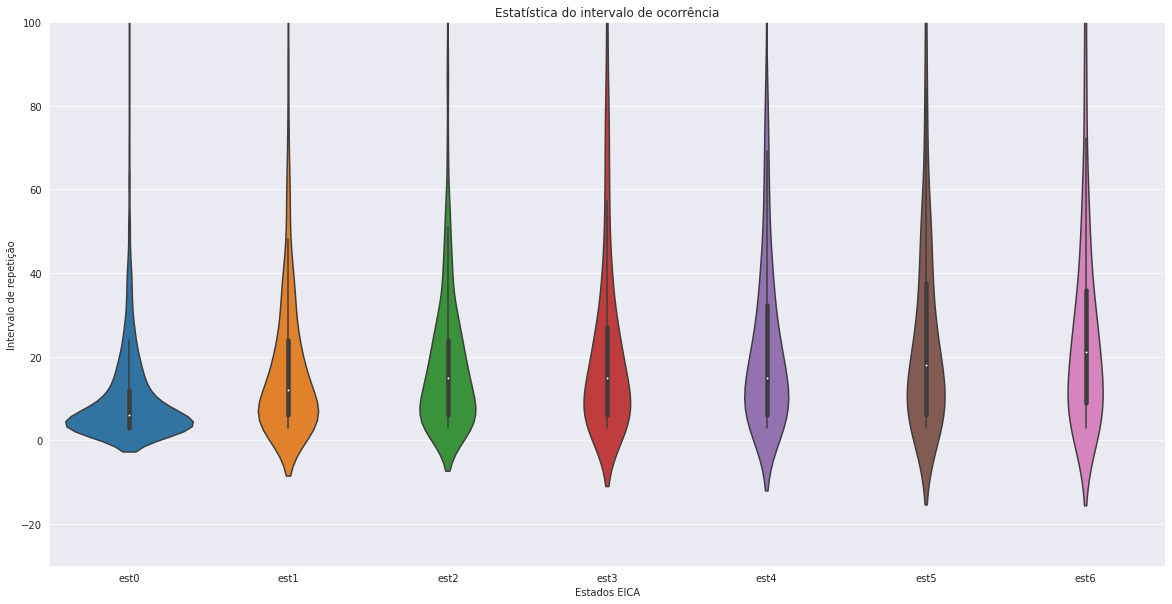

In [13]:
df_states["interval"] = df_states.groupby(["aut", "st"]).tempo.diff()
# df_states
sns.violinplot(x="st", y="interval", data=df_states, order=[f"est{v}" for v in range(7)]).set(
    ylim=(-30,100), title="Estatística do intervalo de ocorrência", xlabel="Estados EICA", ylabel="Intervalo de repetição")
plt.gcf().set_size_inches(20, 10)

## Perfil cognitivo simplificado dos participantes
A distribuição das incidências dos estados EICA característica de cada participante

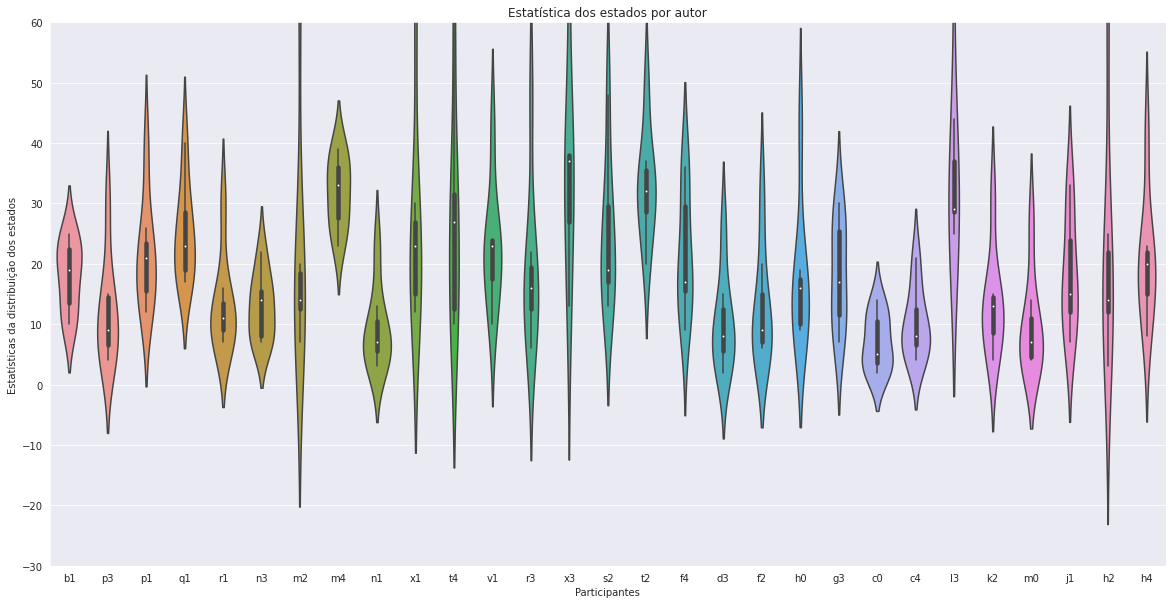

In [14]:
df_st_cnt["stsum"] = df_st_cnt.groupby("aut")["st"].transform('count')#.sum()
d_sst = df_st_cnt.sort_values(by="stsum", ascending=False)
d_sst = d_sst.drop(["stsum"], axis=1)
sns.violinplot(x="aut", y="stc", data=d_sst).set(
    ylim=(-30,60), title="Estatística dos estados por autor", xlabel="Participantes", ylabel="Estatísticas da distribuição dos estados") # , 36, 26, 3])
plt.gcf().set_size_inches(20, 10)


## Contagem de estados por autor
Observando os estados e suas incidências para cada autor.

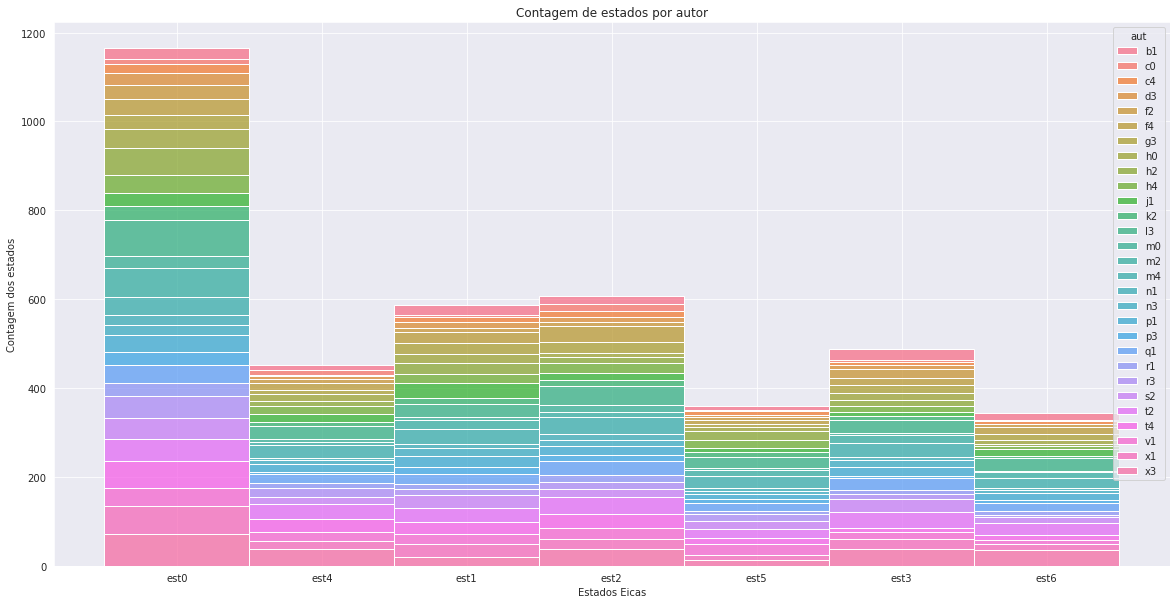

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(x=df_states.st, data=df_states, hue=df_states.aut, bins=28*3, multiple="stack").set(
    title="Contagem de estados por autor", xlabel="Estados Eicas", ylabel="Contagem dos estados")

plt.gcf().set_size_inches(20, 10)
# print((all_states))

## Contagem acumulada de estados por participante
Apresenta numa pilha cumulativa a contagem de incidências de cada estado por participante.

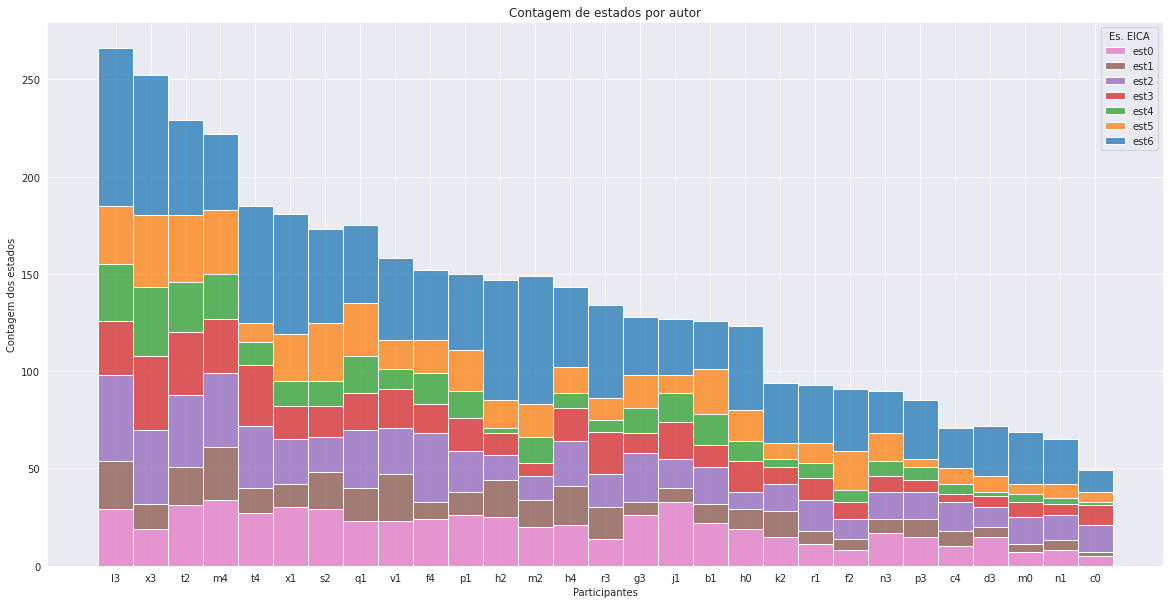

In [16]:
df_states["stsum"] = df_states.groupby("aut")["tempo"].transform('count')#.sum()
d_sst = df_states.sort_values(by="stsum", ascending=False)
d_sst = d_sst.drop(["stsum"], axis=1)

sns.histplot(x=d_sst.aut, data=d_sst, multiple="stack", hue=d_sst.st).set(
    title="Contagem de estados por autor", xlabel="Participantes", ylabel="Contagem dos estados")
plt.legend(title="Es. EICA", loc="upper right", labels=[f"est{s}" for s in range(7)])
plt.gcf().set_size_inches(20, 10)

## Contagem acumulada de palavras de duas letras por participante
Apresenta numa pilha cumulativa a contagem de incidências de cada sequência de dois estado por participante.

,aut,st,tempo,interval,wd3,wd3cnt
1532,l3,est0,546.343829,36.022670,est0est0,54.0
1395,l3,est0,135.085013,3.001889,est0est0,54.0
1353,l3,est0,9.005668,3.001889,est0est0,54.0
1352,l3,est0,6.003778,3.001889,est0est0,54.0
1381,l3,est0,93.058564,3.001889,est0est0,54.0
...,...,...,...,...,...,...
180,c4,est0,9.020882,3.006961,NaN,NaN
280,d3,est1,90.211268,6.014085,NaN,NaN
1640,m0,est0,72.178218,6.014851,NaN,NaN
2078,n1,est0,51.134211,33.086842,NaN,NaN


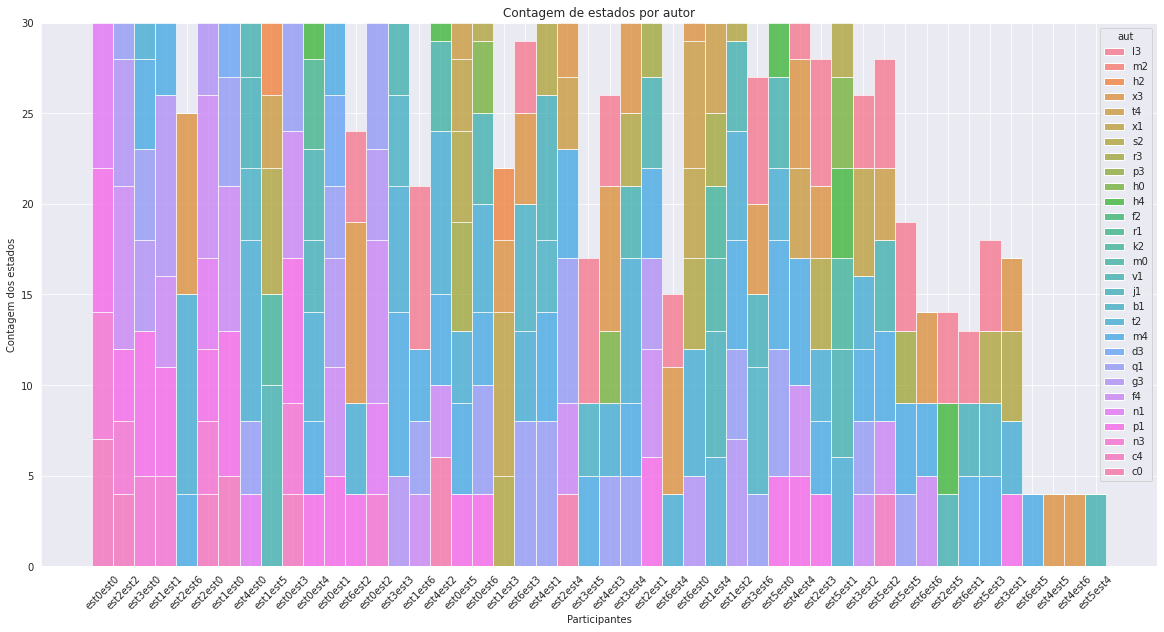

In [17]:
d_sst["wd3"] = d_sst.groupby("aut")["st"].transform(lambda st: st+st.shift(1)) #+st.shift(2))
d_sst["wd3cnt"] = d_sst.groupby(["aut", 'wd3'])["wd3"].transform("count")
d_sst = d_sst.sort_values(by="wd3cnt", ascending=False)
d_sst_ct = d_sst[d_sst["wd3cnt"] >3]
# d_sst = d_sst.drop(["stsum"], axis=1)

sns.histplot(x=d_sst_ct.wd3, data=d_sst_ct, multiple="stack", hue=d_sst_ct.aut).set(ylim=(0,30),
    title="Contagem de estados por autor", xlabel="Participantes", ylabel="Contagem dos estados")
# plt.legend(title="Es. EICA", loc="upper right") #, labels=[f"est{s}" for s in range(7)])
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)
d_sst

## Contagem falantes por língua e línguas por falantes
Agrega as línguas de cada falante e os fallantes de cada língua.

In [18]:
a = d_sst_ct.groupby('aut').agg({'wd3': lambda x: tuple(sorted(set(x))), 'wd3cnt':'count'})
d_sst_dial = a.explode('wd3').reset_index()
s = d_sst_ct.groupby('wd3').agg({'aut': lambda x: tuple(sorted(set(x))), 'wd3cnt':'count'})
d_sst_spk = s.explode('aut').reset_index()
d_sst_dial["dialspk"] = d_sst_dial.groupby('aut')['wd3cnt'].transform('count')
d_sst_dial["spkdial"] = d_sst_dial.groupby('wd3')['wd3cnt'].transform('count')
d_sst_spk["spkdial"] = d_sst_spk.groupby('wd3')['wd3cnt'].transform('count')
d_sst_spk["dialspk"] = d_sst_spk.groupby('aut')['wd3cnt'].transform('count')
d_sst_spk = d_sst_spk[d_sst_spk["dialspk"]>5]
d_sst_dial = d_sst_dial[d_sst_dial["dialspk"]>5]
d_sst_spk = d_sst_spk[d_sst_spk["spkdial"]>2]
d_sst_dial = d_sst_dial[d_sst_dial["spkdial"]>2]

# print(a.explode('wd3'))
print(d_sst_spk.head(15))
d_sst_dial.head(5)

         wd3 aut  wd3cnt  spkdial  dialspk
0   est0est0  b1     438       28       12
1   est0est0  c4     438       28        6
4   est0est0  f4     438       28       16
5   est0est0  g3     438       28       11
6   est0est0  h0     438       28       12
7   est0est0  h2     438       28       12
8   est0est0  h4     438       28       12
9   est0est0  j1     438       28       12
10  est0est0  k2     438       28        6
11  est0est0  l3     438       28       30
13  est0est0  m2     438       28       13
14  est0est0  m4     438       28       32
16  est0est0  n3     438       28        7
17  est0est0  p1     438       28       17
19  est0est0  q1     438       28       21


,aut,wd3,wd3cnt,dialspk,spkdial
0,b1,est0est0,72,12,28
1,b1,est0est2,72,12,18
2,b1,est1est1,72,12,17
3,b1,est2est0,72,12,24
4,b1,est2est2,72,12,12


## Plotagem de falantes por língua.
Agrega os fallantes de cada língua.

,aut,wd3,wd3cnt,dialspk,spkdial
0,b1,est0est0,72,12,28
28,f4,est0est0,98,16,28
276,t2,est0est0,183,29,28
305,t4,est0est0,143,21,28
91,j1,est0est0,71,12,28
...,...,...,...,...,...
176,m4,est3est5,177,32,3
43,f4,est6est6,98,16,3
337,v1,est2est5,113,19,3
171,m4,est2est6,177,32,3


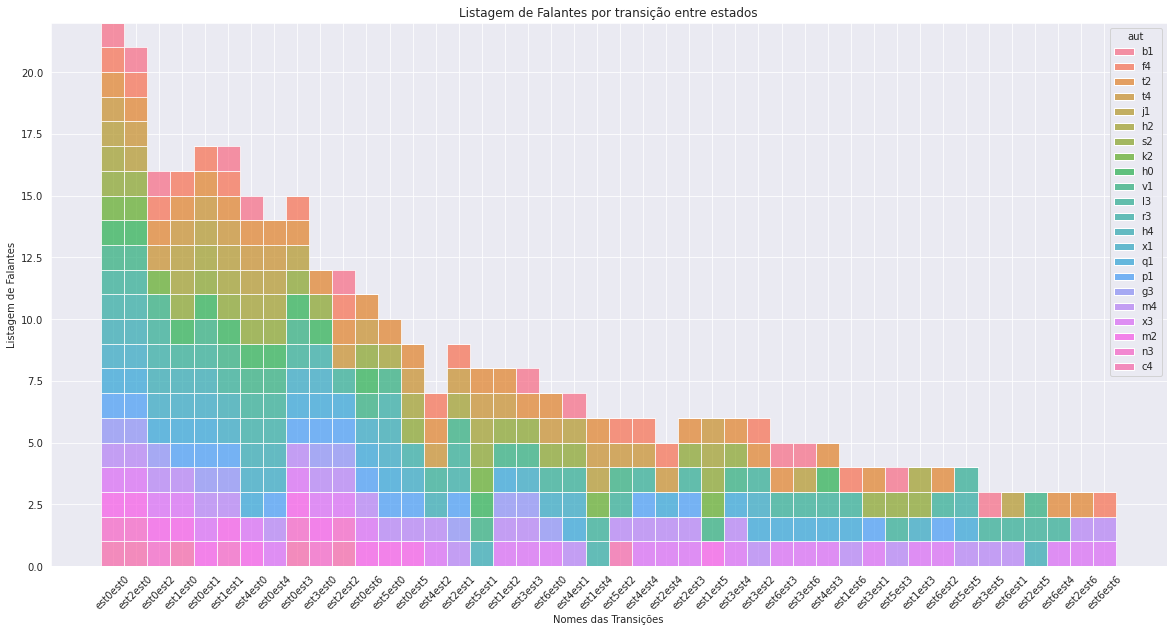

In [19]:
d_sst_dial = d_sst_dial.sort_values(by="spkdial", ascending=False)

sns.histplot(x=d_sst_dial.wd3, data=d_sst_dial, multiple="stack", hue=d_sst_dial.aut).set(
    ylim=(0,22),title="Listagem de Falantes por transição entre estados", xlabel="Nomes das Transições", ylabel="Listagem de Falantes")
#
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)
d_sst_dial

## Contagem de línguas por falantes
Agrega as línguas de cada falante.

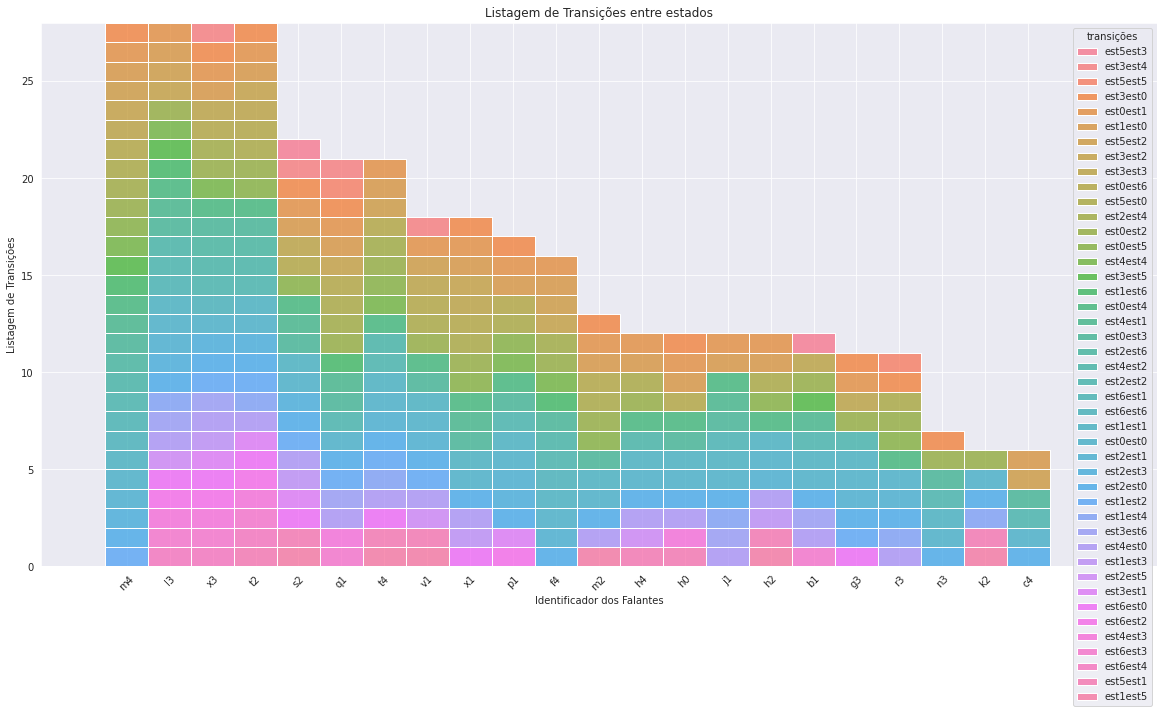

In [20]:
d_sst_spk = d_sst_spk.sort_values(by="dialspk", ascending=False)
d_sst_spk = d_sst_spk.rename(columns = {"wd3": "transições", "dialspk": "incidências", "spkdial": "falantes"})#, "aut": "participantes"})
sns.histplot(x=d_sst_spk.aut, data=d_sst_spk, multiple="stack", hue="transições").set(
    xlim=(-2,24),ylim=(0,28),title="Listagem de Transições entre estados", xlabel="Identificador dos Falantes", ylabel="Listagem de Transições")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Correlação entre transições e falantes dos dialetos

/tmp/ipykernel_22155/2086295231.py:6: UserWarning: 
The palette list has fewer values (21) than needed (22) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(palette=pal, alpha=0.95, data=d_sst_spk,x="transições",y="incidências",hue="participantes", size="falantes", sizes=(300,2000)).set(


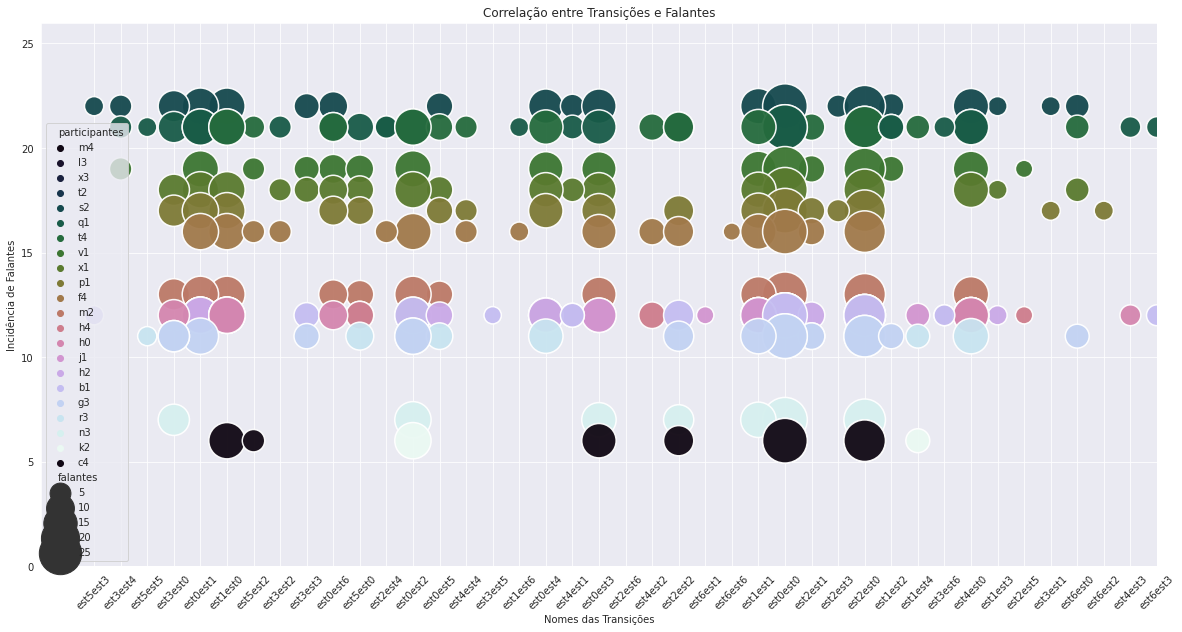

In [21]:
# pal=sns.color_palette("Spectral",21)BrBGPiYGx_jitter=500,y_jitter=300,RdYlBu
pal=sns.color_palette("cubehelix",21)
d_sst_spk = d_sst_spk.rename(columns = {"aut": "participantes"})

#sns.scatterplot(data=d_sst_spk,x="wd3",y="spkdial",hue="aut", size="dialspk", sizes=(100,1000)).set(
sns.scatterplot(palette=pal, alpha=0.95, data=d_sst_spk,x="transições",y="incidências",hue="participantes", size="falantes", sizes=(300,2000)).set(
# sns.scatterplot(data=d_sst_spk,x="spkdial",y="dialspk",hue="aut", sizes=(1000,1000)).set(
    xlim=(-2, 40), ylim=(0, 26), title="Correlação entre Transições e Falantes", xlabel="Nomes das Transições", ylabel="Incidência de Falantes")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

# Recorte dos Eventos em dois Segmentos
Os dados dos eventos é recortado em dois segmentos. O primeiro terá os eventos iniciais e o segundo os finais. O propósito é avaliar a evolução microgenética da cognição. Segue uma comparação na contagem de estados para avaliar a evolução

In [51]:
df_front = df_states[df_states['tempo'] <= 200]
df_back = df_states[(200 < df_states['tempo']) & ( df_states['tempo'] < 400)]
df_back

,aut,st,tempo,interval,stsum
67,b1,est1,201.264474,3.003947,128
68,b1,est1,204.268421,3.003947,128
69,b1,est4,207.272368,27.035526,128
70,b1,est1,210.276316,6.007895,128
71,b1,est1,213.280263,3.003947,128
...,...,...,...,...,...
3931,x3,est0,387.255109,3.001978,254
3932,x3,est0,390.257086,3.001978,254
3933,x3,est1,393.259064,33.021753,254
3934,x3,est0,396.261042,6.003955,254


## Calcula a metade frontal

/tmp/ipykernel_22155/2009106712.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_front["stsumf"] = df_front.groupby("aut")["tempo"].transform('count')#.sum()


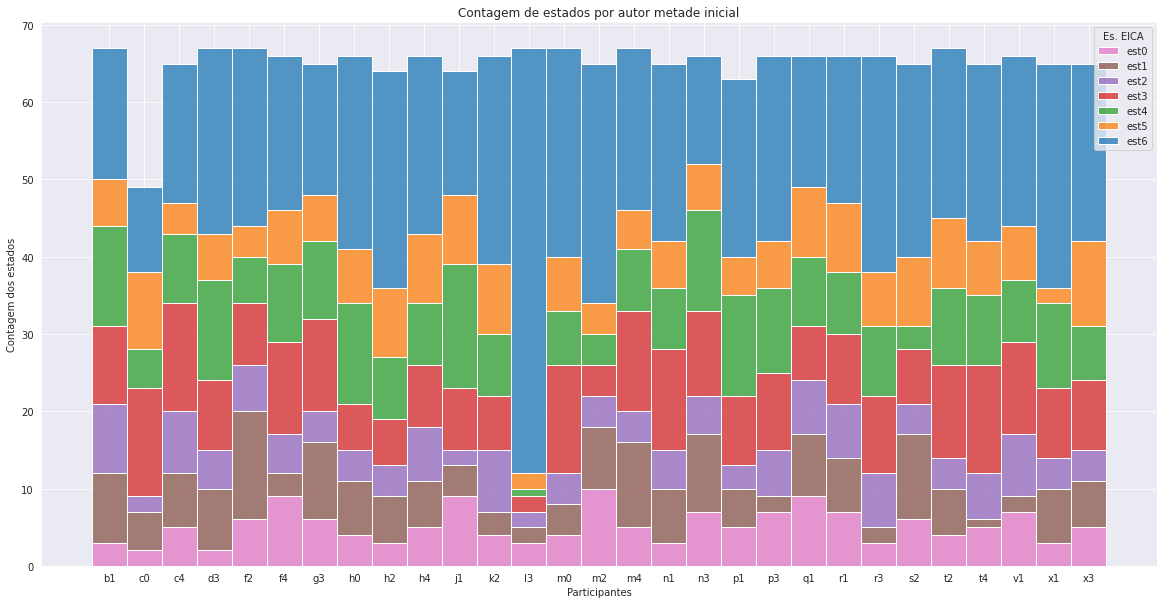

In [52]:
df_front["stsumf"] = df_front.groupby("aut")["tempo"].transform('count')#.sum()
d_sstf = df_front # df_front.sort_values(by="stsumf", ascending=False)
d_sstf = d_sstf.drop(["stsumf"], axis=1)

sns.histplot(x=d_sstf.aut, data=d_sstf, multiple="stack", hue=d_sstf.st).set(
    title="Contagem de estados por autor metade inicial", xlabel="Participantes", ylabel="Contagem dos estados")
plt.legend(title="Es. EICA", loc="upper right", labels=[f"est{s}" for s in range(7)])
plt.gcf().set_size_inches(20, 10)

## Calcula a metade final

/tmp/ipykernel_22155/677902382.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_back["stsumb"] = df_back.groupby("aut")["tempo"].transform('count')#.sum()


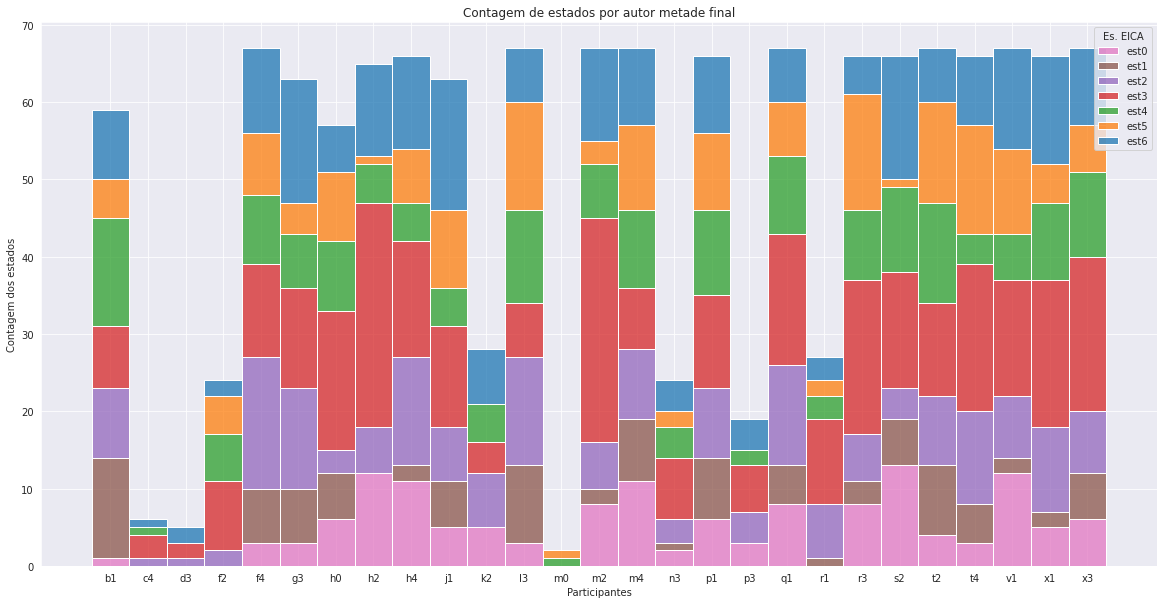

In [53]:
df_back["stsumb"] = df_back.groupby("aut")["tempo"].transform('count')#.sum()
d_sstb = df_back # df_back.sort_values(by="stsumb", ascending=False)
d_sstb = d_sstb.drop(["stsumb"], axis=1)

sns.histplot(x=d_sstb.aut, data=d_sstb, multiple="stack", hue=d_sstb.st).set(
    title="Contagem de estados por autor metade final", xlabel="Participantes", ylabel="Contagem dos estados")
plt.legend(title="Es. EICA", loc="upper right", labels=[f"est{s}" for s in range(7)])
plt.gcf().set_size_inches(20, 10)